In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input,UpSampling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers
import cv2
from tqdm import tqdm
import random
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence

In [2]:
class DenoiseDataGenerator(Sequence):    
    def __init__(self, x_set, batch_size, width, height):
        self.x = x_set
        self.batch_size = batch_size
        self.width  = width
        self.height = height
        self.idx = 0

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = np.array([resize(imread(file_name), (self.width, self.height)) for file_name in batch_x])
        
        return np.array([add_white_noise(np.array(img)) for img in batch_y.copy()]), np.array(batch_y)

In [3]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)
# import zipfile
# with zipfile.ZipFile('../input/notebook36cfb71da3/database-full.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data')


In [3]:
# os.remove('./data/database-full/ image11396.jpg')
# import shutil
# shutil.rmtree('./data/__MACOSX')

In [4]:
img_width, img_height = (256, 256)
BATCH_SIZE = 4

In [5]:
def preprocess_img(img_path):
    dsize = (224,224)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image=np.flip(new_image,axis=-1)
    return new_image

In [6]:
path='./dataset'

In [7]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 10
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    noised = img.copy()
    noised = np.clip(noised, 0., 1.)
    #img = img.astype(np.uint8)
    return noised

def add_white_noise(img):
    #mask = np.random.randint(2, size=(img_width, img_height)).astype(bool)
    mask = np.random.choice([False, True], p=[.85,.15], size=(img_width, img_height))
    noised = img.copy()
    
    for i in range(3):
        noised[:,:,i][mask] = 255.
        
    noised = np.clip(noised, 0., 1.)
    return noised
# datagen_noise = ImageDataGenerator(
#         rescale=1./255,
#         preprocessing_function=add_noise,
#     )
# noise_img=datagen_noise.flow_from_directory(path, target_size=(img_width, img_height), batch_size=BATCH_SIZE,shuffle=False)

In [8]:
full_paths = ['C:/Users/Rod/Desktop/Tarea 3/dataset/database-full/' + x for x in os.listdir('./dataset/database-full/')]

In [9]:
noise_img = DenoiseDataGenerator(full_paths, BATCH_SIZE, img_width, img_height)

In [35]:
datagen = ImageDataGenerator(rescale=1./255)
img_data=datagen.flow_from_directory(path, target_size=(img_width, img_height), class_mode='input', batch_size=BATCH_SIZE,shuffle=False)

Found 31783 images belonging to 1 classes.


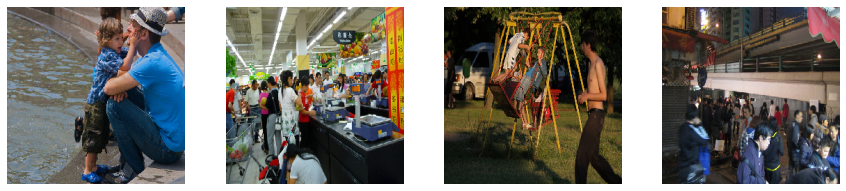

In [36]:
plt.figure(figsize=(15,15))
for images in img_data.next():
    for i in range(4):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(images[i])
        ax.axis("off")

In [172]:
# plt.figure(figsize=(6,6))

# noised, real = noise_img.__getitem__(0)
# for r, n in zip(real, noised):
    
#     #print(r)
#     plt.imshow(r)
#     plt.show()

#     plt.imshow(n)
#     plt.show()   

# Auto Encoder RGB

In [61]:
input_img = keras.Input(shape=(img_width, img_height, 3))

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# LATENT SPACE
latentSize = (8,8,4)

# DECODER
direct_input = keras.Input(shape=latentSize)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(direct_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (2, 2), activation='sigmoid', padding='same')(x)

encoder = keras.Model(input_img, encoded)
decoder = keras.Model(direct_input,decoded)
autoencoder = keras.Model(input_img, decoder(encoded))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
autoencoder.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_132 (Conv2D)         (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_133 (Conv2D)         (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (None, 64, 64, 32)        184

In [63]:
autoencoder.fit(img_data, epochs = 5)

Epoch 1/5
7946/7946 [==============================] - 933s 117ms/step - loss: 0.5639 - accuracy: 0.5382
Epoch 2/5
7946/7946 [==============================] - 930s 117ms/step - loss: 0.5546 - accuracy: 0.6036
Epoch 3/5
7946/7946 [==============================] - 929s 117ms/step - loss: 0.5536 - accuracy: 0.6079
Epoch 4/5
7946/7946 [==============================] - 919s 116ms/step - loss: 0.5531 - accuracy: 0.6092
Epoch 5/5
7946/7946 [==============================] - 940s 118ms/step - loss: 0.5528 - accuracy: 0.6109


In [64]:
autoencoder.save('5_epochs_256_encoded_AE.h5')
encoder.save('5_epochs_256_encoded_E.h5')
decoder.save('5_epochs_256_encoded_D.h5')

# Guardar modelo

In [65]:
encoded_img = encoder.predict(img_data, verbose=1)

7946/7946 [==============================] - 167s 21ms/step


In [66]:
img_names=[x.split(' ')[1] for x in img_data.filenames]

In [67]:
encoded_df=pd.DataFrame({'encoded':[x for x in encoded_img],'img_name':img_names})

In [68]:
encoded_df.head()

,encoded,img_name
0,"[[[0.0, 0.30125657, 0.12232118, 0.27251616], [...",image0.jpg
1,"[[[0.0, 0.31433827, 0.13834836, 0.2321247], [0...",image1.jpg
2,"[[[0.0, 0.59360874, 0.22186047, 0.4218725], [0...",image10.jpg
3,"[[[0.0, 0.40964556, 0.057460107, 0.17976594], ...",image100.jpg
4,"[[[0.0, 0.023629025, 0.11961124, 0.0], [0.0, 0...",image1000.jpg


In [69]:
encoded_df['flattened']=encoded_df.encoded.apply(lambda x : x.flatten())

In [70]:
encoded_df

,encoded,img_name,flattened
0,"[[[0.0, 0.30125657, 0.12232118, 0.27251616], [...",image0.jpg,"[0.0, 0.30125657, 0.12232118, 0.27251616, 0.0,..."
1,"[[[0.0, 0.31433827, 0.13834836, 0.2321247], [0...",image1.jpg,"[0.0, 0.31433827, 0.13834836, 0.2321247, 0.0, ..."
2,"[[[0.0, 0.59360874, 0.22186047, 0.4218725], [0...",image10.jpg,"[0.0, 0.59360874, 0.22186047, 0.4218725, 0.0, ..."
3,"[[[0.0, 0.40964556, 0.057460107, 0.17976594], ...",image100.jpg,"[0.0, 0.40964556, 0.057460107, 0.17976594, 0.0..."
4,"[[[0.0, 0.023629025, 0.11961124, 0.0], [0.0, 0...",image1000.jpg,"[0.0, 0.023629025, 0.11961124, 0.0, 0.0, 0.124..."
...,...,...,...
31778,"[[[0.0, 0.50019026, 0.0, 0.42382064], [0.0, 0....",image9995.jpg,"[0.0, 0.50019026, 0.0, 0.42382064, 0.0, 0.5003..."
31779,"[[[0.0, 0.313702, 0.11561049, 0.4285945], [0.0...",image9996.jpg,"[0.0, 0.313702, 0.11561049, 0.4285945, 0.0, 0...."
31780,"[[[0.0, 0.37674522, 0.2534459, 0.38543138], [0...",image9997.jpg,"[0.0, 0.37674522, 0.2534459, 0.38543138, 0.0, ..."
31781,"[[[0.0, 0.43926483, 0.11645756, 0.31315553], [...",image9998.jpg,"[0.0, 0.43926483, 0.11645756, 0.31315553, 0.0,..."


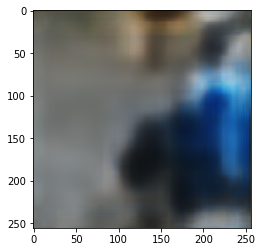

In [72]:
plt.imshow(decoder.predict(np.expand_dims(encoded_df['encoded'][0],axis=0))[0])

# Test Distances


In [73]:
def sorting(tup, reverse=True):
    return(sorted(tup, key = lambda x: x[1],reverse=reverse))

In [74]:
def get_most_similars(query, database):
    
    x2 = database[database.img_name == 'image'+query+'.jpg'].flattened.values[0]
    
    distances = []
    names = []
    for i, fila in database.iterrows():

        x1 = fila.flattened
        names.append(fila.img_name[5:-4])
        distances.append( 1/(1+(np.linalg.norm(x2 - x1))))
        
    distances = [(x,y) for x,y in zip(names, distances)]
    distances=sorting(distances)
        
    return np.array(distances)[:,0]

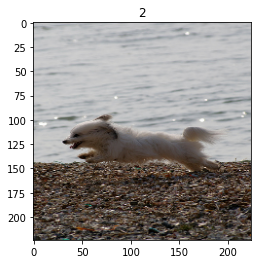

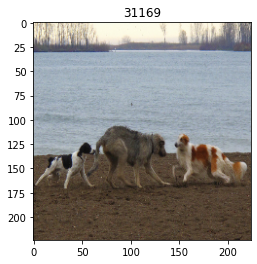

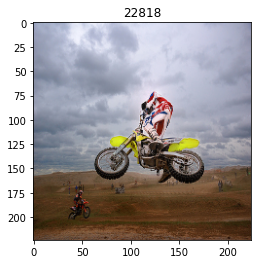

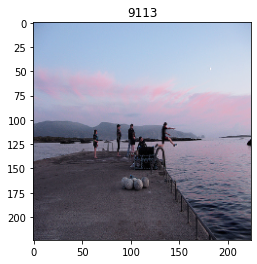

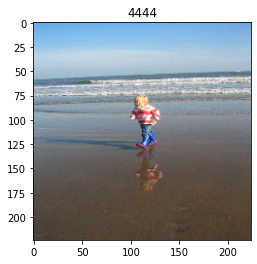

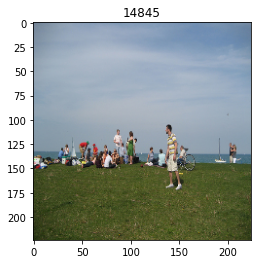

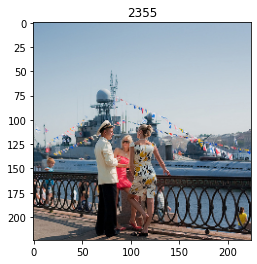

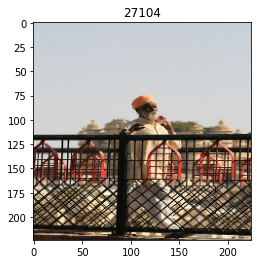

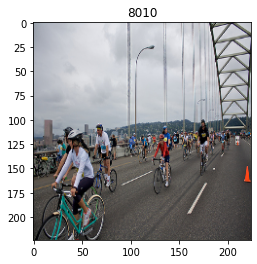

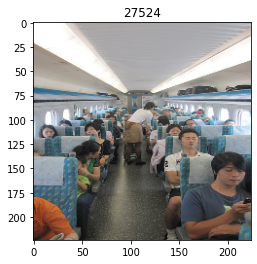

In [77]:
most_sim = get_most_similars('2', encoded_df)
most_sim = most_sim[:10]
for im in most_sim:
    plt.imshow(preprocess_img('dataset/database-full/ image' + im + '.jpg')[0])
    plt.title(im)
    plt.show()

# Test para comparar modelos

In [203]:
example = pd.read_csv('examples_of_retrieval.csv', sep="\t")

In [204]:
retrievals=[]
retrievals.append([x.replace(" ", "") for x in example.columns[0].split(",")])
for i in example.index:
    retrievals.append([x.replace(" ", "") for x in example.iloc[i].values[0].split(",")])

In [206]:
similarities = []
for retrieval in tqdm(retrievals):
    query = retrieval[0][5:-4]
    similarities.append(np.array(get_most_similars(query, encoded_df)[:100]))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


In [207]:
scores = []
for predicted, actual in zip(similarities, retrievals):
    scores.append(mapk(actual, predicted, k=100))

In [208]:
print(np.array(scores).mean())
scores

0.13744827619190786


[0.14632391418105703,
 0.08565634365634363,
 0.06511711972238289,
 0.08162286324786326,
 0.09390476190476191,
 0.07385022385022384,
 0.07539682539682539,
 0.1613095238095238,
 0.07964571271022883,
 0.10888982812059735,
 0.16547619047619047,
 0.09798118548118548,
 0.07230425824175823,
 0.12866300366300365,
 0.3076923076923077,
 0.09217687074829932,
 0.1952380952380952,
 0.068503256003256,
 0.09019741369741369,
 0.08422350922350923,
 0.13160648874934588,
 0.2714285714285714,
 0.08502469752469753,
 0.10592185592185592,
 0.09419780219780219,
 0.24166666666666667,
 0.15,
 0.17032967032967034,
 0.25357142857142856,
 0.0739010989010989,
 0.11043956043956042,
 0.11515567765567765,
 0.15384615384615385,
 0.09674492174492175,
 0.23076923076923078,
 0.35714285714285715,
 0.1386904761904762,
 0.09225651799181213,
 0.0948992673992674,
 0.3076923076923077,
 0.09182067932067932,
 0.11387362637362637,
 0.08164814113089974,
 0.11763329263329263,
 0.12298534798534799,
 0.07603174603174603,
 0.1008928571

# Submission

In [288]:
queries_test = pd.read_csv('names_test_queries.csv', sep="\t", header=None)

In [317]:
len(queries_test)

861

In [357]:
subm_similarities = []
for i, query_ in tqdm(queries_test.iterrows()):
    query = query_[0][6:-4]
    subm_similarities.append(np.array(get_most_similars(query, encoded_df)[1:101]))

861it [36:41,  2.56s/it]


In [358]:
np.array(subm_similarities)

array([['21734', '6847', '2585', ..., '19299', '2694', '21310'],
       ['1889', '3753', '24400', ..., '11523', '9260', '10651'],
       ['22652', '13199', '25157', ..., '13440', '28721', '6901'],
       ...,
       ['1700', '15416', '23369', ..., '29070', '24275', '31038'],
       ['6154', '20931', '21559', ..., '15434', '29918', '23125'],
       ['6666', '16739', '28676', ..., '25288', '6211', '22652']],
      dtype='<U32')

In [373]:
final = pd.DataFrame({'Id': [x[6:-4] for x in queries_test.values.flatten()], 'Expected': [" ".join(x) for x in subm_similarities]})

In [376]:
final = final.set_index('Id')

In [378]:
final.to_csv('submit.csv')

In [380]:
final.Expected[0]

'21734 6847 2585 21756 29526 15034 7389 24374 19911 15232 3966 6712 27618 18687 4508 31029 14114 9364 19952 3769 18511 24497 21781 21995 15906 31455 15040 26253 30485 19830 22035 17715 12582 19996 11079 22986 9389 22896 21577 19689 26282 3799 30465 5062 26306 17154 23125 6721 2310 9210 6460 22506 6402 6019 28245 961 26093 3331 23467 28098 6154 8260 22933 26328 3216 16503 25473 31470 20015 22180 16462 12154 25183 2242 3756 17738 378 22969 9095 24060 5830 27189 22060 29810 18000 21411 12953 21306 23330 6629 23833 23360 14336 25954 23609 3692 23656 19299 2694 21310'